In [1]:
# !pip install catboost

In [1]:
import numpy as np
import pandas as pd

import random

from copy import deepcopy

import matplotlib
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline


random.seed(22)
np.random.seed(22)

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE

import xgboost
from xgboost import XGBRegressor

# from catboost import CatBoostRegressor
# from catboost import Pool, cv
# from catboost import CatBoostClassifier

import time
from datetime import datetime
def to_time(s):
    return datetime.strptime(s, '%Y-%m-%d')

pd.set_option('display.max_columns', None)

In [399]:
from tqdm import tqdm

In [2]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
    return(TP, FP, TN, FN)

In [3]:
train = pd.read_csv("train.csv", sep=';')

In [4]:
# test = pd.read_csv("test.csv", sep=';')

In [5]:
train.sort_values(['hex','period'])[50:].head()

,label,period,subject_type,subject_name,city_name,hex,hex_lat,hex_lon,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
3014,1,2020-07-01,Область,Мурманская,Луостари,860134147ffffff,69.440257,31.060671,0.00050,0.00044,0.00060,0.0,0.0,0.02672,NaN,0.00033,0.00033,0.12823,0.31866,0.15054,0.0,0.0,0.00136,NaN,NaN,0.05288,0.67980,0.31773,0.43103,0.0,0.0,0.22727,0.67482,0.0035,0.00699,0.51399,0.0,0.0
3059,1,2020-07-01,Область,Мурманская,Луостари,860134147ffffff,69.440257,31.060671,NaN,NaN,NaN,0.0,0.0,0.01588,NaN,0.00026,0.00026,0.12478,0.31457,0.14685,NaN,0.0,0.00050,NaN,NaN,0.05288,0.68227,0.31773,0.43350,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
80258,0,2020-07-01,Область,Мурманская,Луостари,860134147ffffff,69.440257,31.060671,0.00000,0.00018,0.00039,0.0,0.0,0.41590,NaN,0.00000,0.00000,0.12478,0.31457,0.14645,0.0,0.0,0.00182,0.01205,NaN,0.05288,0.67980,0.31773,0.43103,0.0,0.0,0.22727,0.67482,0.0035,0.00699,0.51748,0.0,0.0
83524,0,2020-07-01,Область,Мурманская,Луостари,860134147ffffff,69.440257,31.060671,0.00099,0.00178,0.00219,0.0,0.0,0.03840,NaN,0.00000,0.00000,0.12752,0.31457,0.14912,NaN,0.0,0.00085,NaN,NaN,0.05288,0.68227,0.31773,0.43350,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
84221,0,2020-07-01,Область,Мурманская,Луостари,860134147ffffff,69.440257,31.060671,0.00009,0.00022,0.00038,0.0,0.0,0.00135,0.00693,0.00000,0.00000,0.12641,0.31956,0.14805,0.0,0.0,0.00036,0.02410,0.01748,0.05048,0.67980,0.31773,0.43350,0.0,0.0,0.22727,0.67133,0.0035,0.00699,0.51399,0.0,0.0


In [6]:
# test.sort_values(['hex','period'])[-50:].head(30)

In [7]:
train.describe()

,label,hex_lat,hex_lon,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
count,294258.000000,294258.000000,294258.000000,258144.000000,262930.000000,265786.000000,279564.000000,279564.000000,281984.000000,148829.000000,280209.000000,280209.000000,294258.000000,294258.000000,294258.000000,166853.000000,286618.000000,277160.000000,153723.000000,148829.000000,294124.000000,286899.000000,286899.000000,286899.000000,286899.000000,286899.000000,167474.000000,167474.000000,167474.000000,167474.000000,167474.000000,286899.000000,286899.000000
mean,0.024149,54.732133,55.154934,0.000573,0.000591,0.000745,0.000902,0.000247,0.157069,0.000169,0.000690,0.000955,0.126545,0.317709,0.148264,0.000081,0.000038,0.002789,0.022622,0.057591,0.020186,0.514443,0.024963,0.158855,0.029383,0.000303,0.118867,0.537152,0.003187,0.008172,0.186825,0.008941,0.000097
std,0.153512,5.101274,27.235237,0.001142,0.001101,0.001267,0.003160,0.001825,0.175730,0.002208,0.004673,0.005670,0.001089,0.003897,0.001139,0.002148,0.001337,0.008487,0.005559,0.060616,0.048114,0.175017,0.027384,0.116387,0.059065,0.001089,0.119459,0.273556,0.005874,0.011134,0.284884,0.011068,0.000929
min,0.000000,41.579243,19.920451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103030,0.211720,0.125960,0.000000,0.000000,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,52.599710,37.762513,0.000110,0.000120,0.000160,0.000000,0.000000,0.019820,0.000000,0.000000,0.000000,0.126010,0.314570,0.147660,0.000000,0.000000,0.000780,0.024100,0.010310,0.003980,0.400470,0.011110,0.076490,0.000000,0.000000,0.010160,0.535010,0.000000,0.000000,0.009430,0.001730,0.000000
50%,0.000000,55.345232,44.032430,0.000330,0.000350,0.000450,0.000000,0.000000,0.056150,0.000000,0.000000,0.000000,0.126550,0.317470,0.148180,0.000000,0.000000,0.002000,0.024100,0.039480,0.009480,0.532470,0.019230,0.119050,0.000000,0.000000,0.084110,0.630740,0.000000,0.005330,0.036440,0.006410,0.000000
75%,0.000000,56.994743,60.827859,0.000740,0.000760,0.000970,0.000000,0.000000,0.414520,0.000000,0.000000,0.000000,0.127000,0.319610,0.148780,0.000000,0.000000,0.003800,0.024100,0.086260,0.020650,0.641320,0.028820,0.198240,0.039150,0.000000,0.206473,0.705880,0.004850,0.011490,0.276010,0.012170,0.000000
max,1.000000,69.725102,170.350467,0.314800,0.292930,0.279930,0.206900,0.078260,0.995900,0.541940,0.470790,0.510130,0.144930,0.494830,0.177740,0.285710,0.090910,0.998260,0.240960,0.629200,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,0.500000,0.500000,1.000000,1.000000,0.250000


In [8]:
# test.describe()

In [9]:
for col in train:
    print(col, end = ' ')
    print(len(train[col].unique()))

label 2
period 8
subject_type 6
subject_name 82
city_name 4634
hex 7250
hex_lat 7250
hex_lon 7250
f1 959
f2 967
f3 1128
f4 36
f5 11
f6 6077
f7 117
f8 658
f9 450
f10 1008
f11 3008
f12 1313
f13 6
f14 4
f15 1672
f16 10
f17 22474
f18 5458
f19 22642
f20 4889
f21 16398
f22 7574
f23 611
f24 9948
f25 10987
f26 1398
f27 2419
f28 9542
f29 3241
f30 432


# Some tests

In [254]:
import scipy.stats as ss
import seaborn as sns

In [255]:
train_label_yes = train.loc[train['label'] == 1]
train_label_no = train.loc[train['label'] == 0]

In [256]:
def mann_test(df1, df2, num):
    col = 'f' + str(num)
    row1 = np.array(train_label_yes[col].dropna())
    row2 = np.array(train_label_no[col].dropna())
    return ss.mannwhitneyu(row1, row2)

In [257]:
mann_test(train_label_yes, train_label_no, 1)

MannwhitneyuResult(statistic=1097774275.5, pvalue=0.0)

In [258]:
mann_res = []

In [259]:
for i in range(1, 31):
    res = mann_test(train_label_yes, train_label_no, i)[1]
    if res < 0.01:
        mann_res.append(i)

In [260]:
def t_test(df1, df2, num):
    col = 'f' + str(num)
    row1 = np.array(train_label_yes[col].dropna())
    row2 = np.array(train_label_no[col].dropna())
    return ss.ttest_ind(row1, row2, equal_var=False)

In [261]:
t_test(train_label_yes, train_label_no, 1)

Ttest_indResult(statistic=9.757610228680297, pvalue=2.401495233922568e-22)

In [262]:
t_res = []

In [263]:
for i in range(1, 31):
    res = t_test(train_label_yes, train_label_no, i)[1]
    if res < 0.01:
        t_res.append(i)

In [264]:
diffs = set(mann_res) & set(t_res)
print(diffs)

{1, 2, 3, 4, 8, 9, 10, 11, 12, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


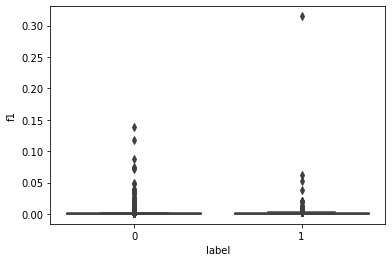

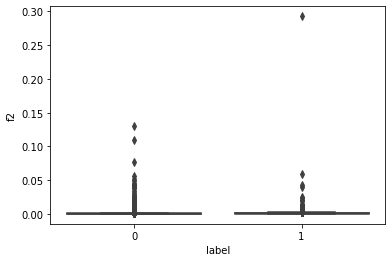

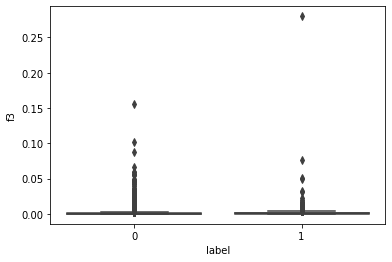

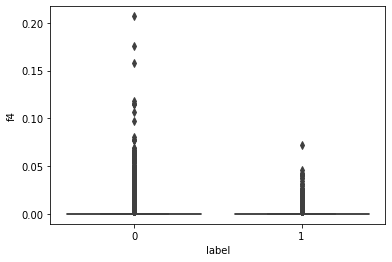

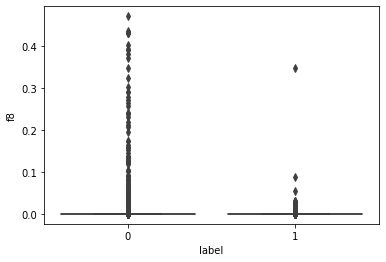

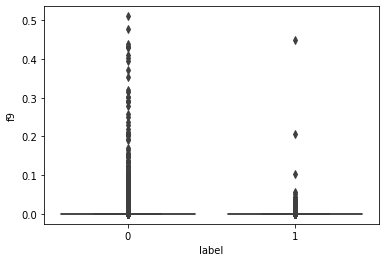

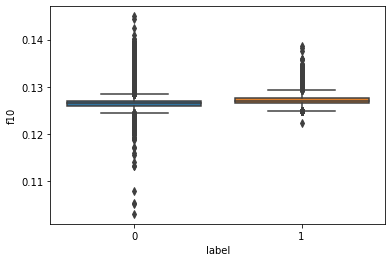

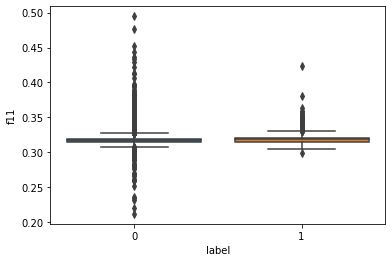

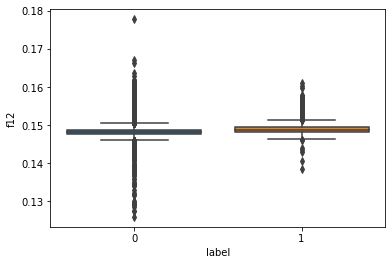

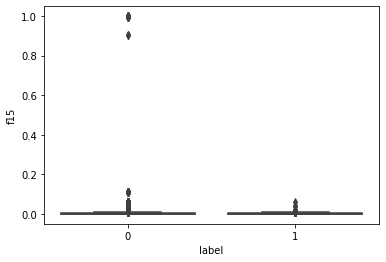

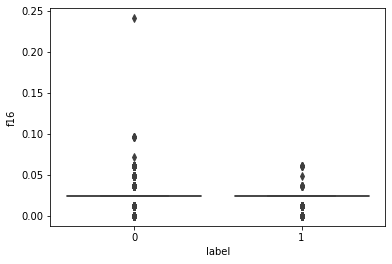

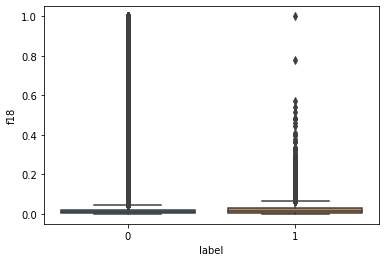

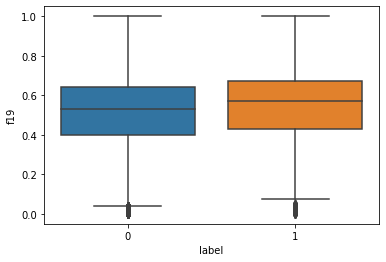

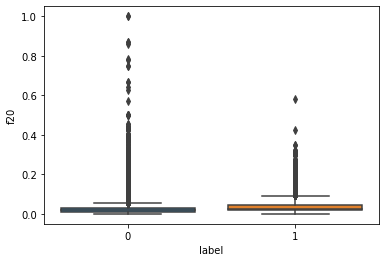

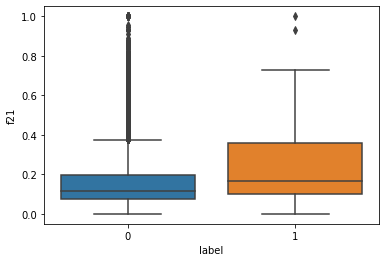

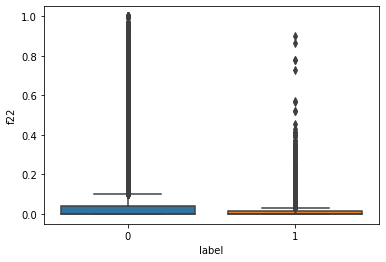

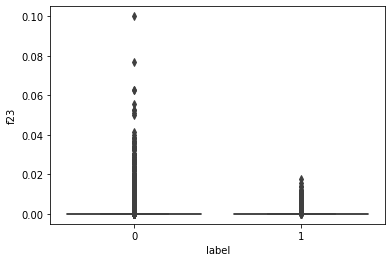

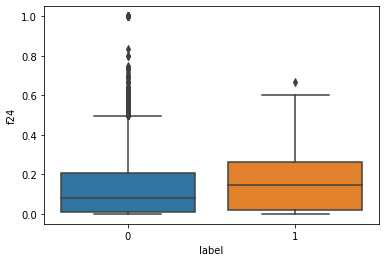

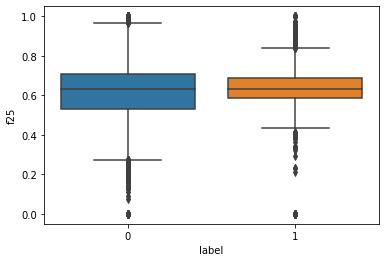

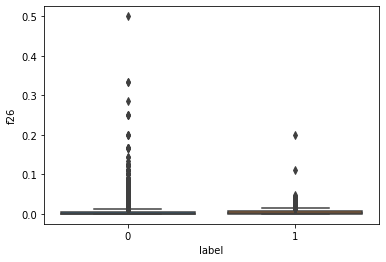

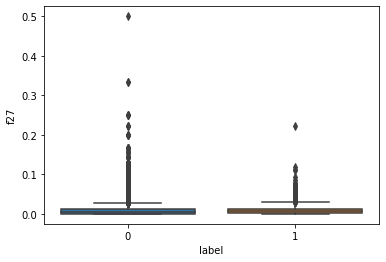

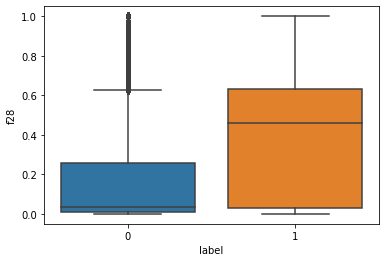

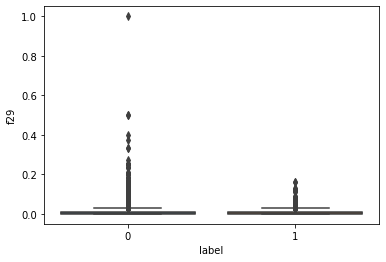

In [265]:
for k in diffs:
    col = 'f' + str(k)
    sns.boxplot(x='label', y=col, data=train)
    plt.show()

Будем генерить прогноз следующим образом:
- пускай мы знаем, как ведут себя чуваки, которые покупают
- если хотя бы для половины фич выполняется условие, то мы считаем, что чел купит

Для начала найдем не только значимые, но и значительные отличия

In [266]:
signy = []
alpha = 0.89 # по сути это гиперпараметр, который можно подобрать

In [267]:
for k in diffs:
    col = 'f' + str(k)
    row1 = np.array(train_label_yes[col].dropna())
    row2 = np.array(train_label_no[col].dropna())
    stat = (np.mean(row1) - np.mean(row2)) / np.mean(row1)
    if (stat > 1 + alpha) or (stat < 1 - alpha):
        signy.append(k)

In [268]:
print(signy)

[8, 9, 10, 11, 12, 15, 16, 19, 22, 25, 29]


Пишем классификатор

In [269]:
all_deltas = []

In [270]:
for k in signy:
    col = 'f' + str(k)
    row1 = np.array(train_label_yes[col].dropna())
    row2 = np.array(train_label_no[col].dropna())
    
    delta = np.mean(row1) - np.mean(row2)
    all_deltas.append(delta)

In [271]:
l = len(signy)
all_means_signy = np.zeros(l)

In [272]:
for k in range(l):
    col = 'f' + str(signy[k])
    row1 = np.array(train_label_yes[col].dropna())
    all_means_signy[k] = np.mean(row1)

In [273]:
def classifier(observation, deltas, means, sign):
    half = len(sign) // 2
    score = 0
    for k in range(len(sign)):
        col = 'f' + str(sign[k])
        if (deltas[k] < 0) and (observation[col] < means[k]):
            score += 1
        if (deltas[k] > 0) and (observation[col] > means[k]):
            score += 1
            
    if score > half:
        return 1
    else:
        return 0

In [274]:
x = train.iloc[1]

In [275]:
print(all_deltas)
print(all_means_signy)
print(signy)

[-0.0002842850115745869, -0.00034494900949359427, 0.0005707549121027333, 0.0017933066204540715, 0.0006845419466147973, -0.0003661058559613524, 0.000393364197619369, 0.028892794677194633, -0.00865485051294448, 0.06021962794999858, -0.0008018175889742095]
[4.13300339e-04 6.18887161e-04 1.27101904e-01 3.19459263e-01
 1.48931538e-01 2.43248200e-03 2.30029273e-02 5.42623038e-01
 2.09411756e-02 5.95565852e-01 8.15890773e-03]
[8, 9, 10, 11, 12, 15, 16, 19, 22, 25, 29]


In [276]:
classifier(x, all_deltas, all_means_signy, signy)

0

Протестируем наш классификатор

In [277]:
num_row_train = train.shape[0]

pred_y = np.zeros(num_row_train)
for i in tqdm(range(num_row_train)):
    x = train.iloc[i]
    pred_y[i] = classifier(x, all_deltas, all_means_signy, signy)
    
metrics = perf_measure(np.array(train['label']), pred_y)

100%|████████████████████████████████████████████████████████████████████████| 294258/294258 [01:15<00:00, 3899.31it/s]


In [278]:
metrics

(5180, 135916, 151236, 1926)

In [279]:
TP, FP, TN, FN = metrics[0], metrics[1], metrics[2], metrics[3]
print(f'accuracy: {(TP + TN) / np.sum(metrics)}')
precision = (TP) / (TP + FP)
print(f'precision: {precision}')
recall = TP / (TP + FN)
print(f'recall: {recall}')

accuracy: 0.5315607392152465
precision: 0.03671259284458808
recall: 0.7289614410357445


In [280]:
f1 = 2 * recall * precision / (precision + recall)
print(f'f1: {f1}')

f1: 0.06990458968165073


# Типа байесовский классификатор

In [281]:
features = []
for k in range(l):
    col = 'f' + str(signy[k])
    features.append(col)

In [282]:
features.append('label')

In [283]:
train_sel = train[features]

In [284]:
train_sel_yes = train_sel.loc[train_sel['label'] == 1]
train_sel_no = train_sel.loc[train_sel['label'] == 0]

In [285]:
train_sel_yes = train_sel_yes.drop(['label'], axis=1)

In [286]:
train_sel_no = train_sel_no.drop(['label'], axis=1)

In [287]:
cov_mat_yes = train_sel_yes.cov()
cov_mat_yes_np = np.array(cov_mat_yes)

In [288]:
cov_mat_no = train_sel_no.cov()
cov_mat_no_np = np.array(cov_mat_no)

In [289]:
mean_yes = train_sel_yes.mean()
mean_yes_np = np.array(mean_yes)

In [290]:
mean_no = train_sel_no.mean()
mean_no_np = np.array(mean_no)

In [291]:
rv_yes = ss.multivariate_normal(mean_yes, cov_mat_yes)
rv_no = ss.multivariate_normal(mean_no, cov_mat_no)

In [292]:
train_sel_sel = train_sel.drop(['label'], axis=1)

In [293]:
train_sel_sel = train_sel_sel.fillna(0)

In [294]:
x = np.array(train_sel_sel.iloc[0])

In [295]:
x

array([0.     , 0.     , 0.12653, 0.33941, 0.14816, 0.00428, 0.     ,
       0.26303, 0.     , 0.     , 0.01737])

In [296]:
rv_yes.pdf(x)

18129.19803452

In [297]:
rv_no.pdf(x)

91.45102069804517

In [298]:
a = rv_yes.pdf(x)
b = rv_no.pdf(x)
rule = a / (a + b)
rule

0.994980913115614

In [317]:
le = train_sel_sel.shape[0]
probs = np.zeros(le)
ans = np.zeros(le)
for i in tqdm(range(le)):
    x = np.array(train_sel_sel.iloc[i])
    a = rv_yes.pdf(x)
    b = rv_no.pdf(x)
    rule = a / (a + b)
    probs[i] = rule
    if rule > 0.90:
        ans[i] = 1

  1%|▋                                                                         | 2559/294258 [00:00<00:55, 5213.79it/s]C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
100%|████████████████████████████████████████████████████████████████████████| 294258/294258 [00:51<00:00, 5660.00it/s]


In [318]:
metrics = perf_measure(np.array(train['label']), ans)

In [319]:
TP, FP, TN, FN = metrics[0], metrics[1], metrics[2], metrics[3]
print(f'accuracy: {(TP + TN) / np.sum(metrics)}')
precision = (TP) / (TP + FP)
print(f'precision: {precision}')
recall = TP / (TP + FN)
print(f'recall: {recall}')
f1 = 2 * recall * precision / (precision + recall)
print(f'f1: {f1}')

accuracy: 0.9179053755547852
precision: 0.08234948317248812
recall: 0.2365606529693217
f1: 0.12217013699625713


In [341]:
c = pd.DataFrame(probs).dropna()
ind = c.sort_values(by=0)[-int(len(c)*0.05):].index

In [342]:
len(ind)

14709

In [343]:
some_sel_pd = train.iloc[ind]
some_sel_pd['label'].sum() / len(ind)

0.08097083418315316

In [349]:
train['probs'] = probs

In [358]:
train['pred'] = round(train['label'] - train['probs'] + 0.3, 0)

In [360]:
# TP, FP, TN, FN
metrics = perf_measure(train['label'], train['pred'])

In [361]:
TP, FP, TN, FN = metrics[0], metrics[1], metrics[2], metrics[3]
print(f'accuracy: {(TP + TN) / np.sum(metrics)}')
precision = (TP) / (TP + FP)
print(f'precision: {precision}')
recall = TP / (TP + FN)
print(f'recall: {recall}')
f1 = 2 * recall * precision / (precision + recall)
print(f'f1: {f1}')

accuracy: 0.9899440828323212
precision: 1.0
recall: 0.6296452702702703
f1: 0.7727390515677637


In [364]:
test_sel = test[features]

In [365]:
test_sel_sel = test_sel.drop(['label'], axis=1)
test_sel_sel = test_sel_sel.fillna(0)

In [367]:
le = test_sel_sel.shape[0]
probs = np.zeros(le)
ans = np.zeros(le)
for i in tqdm(range(le)):
    x = np.array(train_sel_sel.iloc[i])
    a = rv_yes.pdf(x)
    b = rv_no.pdf(x)
    rule = a / (a + b)
    probs[i] = rule
    if rule > 0.90:
        ans[i] = 1

  1%|█                                                                         | 2288/152766 [00:00<00:31, 4849.24it/s]C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
100%|████████████████████████████████████████████████████████████████████████| 152766/152766 [00:30<00:00, 5030.44it/s]


In [368]:
test['probs'] = probs
test['pred'] = round(test['label'] - test['probs'] + 0.3, 0)

In [370]:
# TP, FP, TN, FN
metrics = perf_measure(test['label'], test['pred'])
TP, FP, TN, FN = metrics[0], metrics[1], metrics[2], metrics[3]
print(f'accuracy: {(TP + TN) / np.sum(metrics)}')
precision = (TP) / (TP + FP)
print(f'precision: {precision}')
recall = TP / (TP + FN)
print(f'recall: {recall}')
f1 = 2 * recall * precision / (precision + recall)
print(f'f1: {f1}')

accuracy: 0.9896770207752651
precision: 1.0
recall: 0.5533105377681069
f1: 0.7124274564738843


In [386]:
test_test = pd.read_csv('test dataset.csv', sep=';')

In [387]:
test_test.head()

,label,period,subject_type,subject_name,city_name,hex,hex_lat,hex_lon,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,id
0,0,2020-11-01,Город,Москва,Москва,8611aa627ffffff,55.855726,37.669858,0.00115,0.00082,0.00099,0.0,0.0,0.01028,NaN,0.0,0.0,0.12721,0.31457,0.14915,NaN,0.0,0.00503,NaN,NaN,0.00898,0.29623,0.02424,0.14273,0.0,0.00000,NaN,NaN,NaN,NaN,NaN,0.00449,0.0,1
1,0,2020-11-01,Город,Москва,Москва,8611aa797ffffff,55.647024,37.609130,0.00206,0.00242,0.00340,0.0,0.0,0.02266,0.00025,0.0,0.0,0.12628,0.32275,0.14791,0.0,0.0,0.00123,0.0241,0.00936,0.01720,0.23342,0.02948,0.14251,0.0,0.00000,0.07368,0.63158,0.01053,0.04210,0.02105,0.00491,0.0,2
2,0,2020-11-01,Город,Москва,Москва,8611aa71fffffff,55.821708,37.589846,0.00082,0.00068,0.00082,0.0,0.0,0.01098,0.00000,0.0,0.0,0.12606,0.31983,0.14770,0.0,0.0,0.00048,0.0241,0.00002,0.00559,0.24980,0.02314,0.15323,0.0,0.00000,0.14058,0.67093,0.00958,0.03195,0.00320,0.00798,0.0,3
3,0,2020-11-01,Город,Москва,Москва,8611aa627ffffff,55.855726,37.669858,0.00118,0.00195,0.00258,0.0,0.0,0.01306,NaN,0.0,0.0,0.12664,0.32194,0.14826,NaN,0.0,0.00254,NaN,NaN,0.01207,0.22624,0.03017,0.16139,0.0,0.00151,NaN,NaN,NaN,NaN,NaN,0.00905,0.0,4
4,0,2020-11-01,Город,Москва,Москва,8611aa4efffffff,55.637199,37.443663,0.00079,0.00092,0.00096,0.0,0.0,0.41867,NaN,0.0,0.0,0.12606,0.32012,0.14770,NaN,0.0,0.00244,NaN,NaN,0.01532,0.23398,0.02925,0.12674,0.0,0.00000,NaN,NaN,NaN,NaN,NaN,0.01254,0.0,5


In [388]:
test_test_sel = test_test[features]
test_test_sel_sel = test_test_sel.drop(['label'], axis=1)
test_test_sel_sel = test_test_sel_sel.fillna(0)

In [389]:
le = test_test_sel_sel.shape[0]
probs = np.zeros(le)
ans = np.zeros(le)
for i in tqdm(range(le)):
    x = np.array(test_test_sel_sel.iloc[i])
    a = rv_yes.pdf(x)
    b = rv_no.pdf(x)
    rule = a / (a + b)
    probs[i] = rule
    if rule > 0.90:
        ans[i] = 1

  0%|▎                                                                          | 615/151791 [00:00<00:47, 3188.55it/s]C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
100%|████████████████████████████████████████████████████████████████████████| 151791/151791 [00:29<00:00, 5160.41it/s]


In [390]:
test_test['probs'] = probs

In [391]:
test_test

,label,period,subject_type,subject_name,city_name,hex,hex_lat,hex_lon,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,id,probs
0,0,2020-11-01,Город,Москва,Москва,8611aa627ffffff,55.855726,37.669858,0.00115,0.00082,0.00099,0.00000,0.0,0.01028,NaN,0.00000,0.00000,0.12721,0.31457,0.14915,NaN,0.0,0.00503,NaN,NaN,0.00898,0.29623,0.02424,0.14273,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,0.00449,0.00000,1,0.004242
1,0,2020-11-01,Город,Москва,Москва,8611aa797ffffff,55.647024,37.609130,0.00206,0.00242,0.00340,0.00000,0.0,0.02266,0.00025,0.00000,0.00000,0.12628,0.32275,0.14791,0.0,0.0,0.00123,0.0241,0.00936,0.01720,0.23342,0.02948,0.14251,0.00000,0.00000,0.07368,0.63158,0.01053,0.04210,0.02105,0.00491,0.00000,2,0.792934
2,0,2020-11-01,Город,Москва,Москва,8611aa71fffffff,55.821708,37.589846,0.00082,0.00068,0.00082,0.00000,0.0,0.01098,0.00000,0.00000,0.00000,0.12606,0.31983,0.14770,0.0,0.0,0.00048,0.0241,0.00002,0.00559,0.24980,0.02314,0.15323,0.00000,0.00000,0.14058,0.67093,0.00958,0.03195,0.00320,0.00798,0.00000,3,0.596743
3,0,2020-11-01,Город,Москва,Москва,8611aa627ffffff,55.855726,37.669858,0.00118,0.00195,0.00258,0.00000,0.0,0.01306,NaN,0.00000,0.00000,0.12664,0.32194,0.14826,NaN,0.0,0.00254,NaN,NaN,0.01207,0.22624,0.03017,0.16139,0.00000,0.00151,NaN,NaN,NaN,NaN,NaN,0.00905,0.00000,4,0.042549
4,0,2020-11-01,Город,Москва,Москва,8611aa4efffffff,55.637199,37.443663,0.00079,0.00092,0.00096,0.00000,0.0,0.41867,NaN,0.00000,0.00000,0.12606,0.32012,0.14770,NaN,0.0,0.00244,NaN,NaN,0.01532,0.23398,0.02925,0.12674,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,0.01254,0.00000,5,0.026755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151786,0,2021-06-01,Край,Приморский,Артем,86316c8d7ffffff,43.352653,132.244424,0.00043,0.00051,0.00058,0.00000,0.0,0.25940,0.00000,0.00000,0.00000,0.12708,0.32035,0.14869,0.0,0.0,0.00063,0.0241,0.09569,0.06061,0.69403,0.02985,0.26119,0.04478,0.00000,0.30208,0.54167,0.00000,0.00000,0.09375,0.05224,0.00000,151787,0.622479
151787,0,2021-06-01,Край,Хабаровский,Хабаровск,8614d64f7ffffff,48.466982,135.139503,0.00012,0.00013,0.00016,0.02299,0.0,0.02163,NaN,0.00066,0.00066,0.12832,0.31457,0.15062,NaN,0.0,0.00080,NaN,NaN,0.23810,0.85714,0.00000,0.38095,0.19048,0.00000,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,151788,0.013616
151788,0,2021-06-01,Край,Хабаровский,Хабаровск,8614d641fffffff,48.506809,135.084491,0.00032,0.00032,0.00042,0.00000,0.0,0.02041,NaN,0.00000,0.00000,0.12615,0.31866,0.14779,0.0,0.0,0.00192,NaN,NaN,0.04688,0.58851,0.03028,0.22360,0.28571,0.00000,0.07370,0.64803,0.00508,0.01271,0.05591,0.03028,0.00000,151789,0.032976
151789,0,2021-06-01,Область,Амурская,Свободный,8614ac06fffffff,51.369961,128.109785,0.00013,0.00013,0.00016,0.00000,0.0,0.42413,NaN,0.00000,0.00000,0.12783,0.31457,0.14943,NaN,0.0,0.00183,NaN,NaN,0.11045,0.74810,0.04552,0.22003,0.29590,0.00000,NaN,NaN,NaN,NaN,NaN,0.03794,0.00152,151790,0.014774


In [398]:
test_test.loc[:, 'probs'].dropna().sort_values()

86948     0.0
49308     0.0
22026     0.0
73762     0.0
96464     0.0
         ... 
14838     1.0
136377    1.0
136422    1.0
136147    1.0
26165     1.0
Name: probs, Length: 151775, dtype: float64

In [393]:
cum = pd.DataFrame(probs).dropna()
ind = cum.sort_values(by=0)[-int(len(c)*0.05):].index

In [394]:
ind

Int64Index([132464, 148972, 134434,  61463, 146421, 136445, 114212, 105311,
            137261, 139034,
            ...
             91265, 148012,  10838, 148290, 146240,  14838, 136377, 136422,
            136147,  26165],
           dtype='int64', length=14709)

In [402]:
test_test['probs'].iloc[ind].to_csv('answers.csv')